In [1]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
descript-audiotools 0.7.4 requires protobuf!=4.24.0,<5.0.0,>=3.19.6, but you have protobuf 5.29.4 which is incompatible.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.4 which is incompatible.
diffprivlib 0.6.6 requires numpy>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import umap
import numpy as np
from tqdm import tqdm
import random
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('pre-processed-articles.csv')

In [5]:
df = df.dropna(subset=['text', 'stance'])  # remove missing text/stance
df['text'] = df['text'].fillna('')  # if any weird blanks
df['stance'] = df['stance'].str.lower()  # normalize labels

In [6]:
# encode stance (pro -> 0, anti -> 1)
le = LabelEncoder()
df['stance_encoded'] = le.fit_transform(df['stance'])
print(le.classes_)

['anti' 'pro']


In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('using device:', device)

using device: mps


In [8]:
# small model for embeddings
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert = AutoModel.from_pretrained('distilbert-base-uncased').to(device)
bert.eval()  # no training the encoder itself

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [9]:
class TripletTextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.labels = df['stance_encoded'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anchor_text = self.df.iloc[idx]['text']
        anchor_label = self.labels[idx]
        
        # select positive
        pos_idx = random.choice(self.df[self.labels == anchor_label].index)
        positive_text = self.df.loc[pos_idx]['text']

        # select negative
        neg_idx = random.choice(self.df[self.labels != anchor_label].index)
        negative_text = self.df.loc[neg_idx]['text']

        return anchor_text, positive_text, negative_text, anchor_label

def encode_text(text_list, tokenizer, device):
    encodings = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    return input_ids, attention_mask

In [10]:
class EmbeddingNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.embedding_dim = 768  # distilbert output size
        self.fc = nn.Linear(self.embedding_dim, 128)  # shrink size for triplet loss

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0]
        return self.fc(pooled_output)

In [11]:
def train_triplet(model, dataset, epochs=10, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.TripletMarginLoss(margin=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for anchor, positive, negative, _ in pbar:
            anchor_ids, anchor_mask = encode_text(anchor, tokenizer, device)
            positive_ids, positive_mask = encode_text(positive, tokenizer, device)
            negative_ids, negative_mask = encode_text(negative, tokenizer, device)

            anchor_emb = model(anchor_ids, anchor_mask)
            positive_emb = model(positive_ids, positive_mask)
            negative_emb = model(negative_ids, negative_mask)

            loss = criterion(anchor_emb, positive_emb, negative_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
        
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
    
    return losses

In [12]:
def plot_loss(losses):
    plt.plot(losses, marker='o')
    plt.title("Triplet Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

In [13]:
def visualize_embeddings(model, df, n_samples=200):
    model.eval()
    
    texts = df.sample(n=n_samples, random_state=42)['text'].tolist()
    labels = df.sample(n=n_samples, random_state=42)['stance_encoded'].tolist()
    
    input_ids, attention_mask = encode_text(texts, tokenizer, device)
    embeddings = model(input_ids, attention_mask).detach().cpu().numpy()
    
    reducer = umap.UMAP()
    emb_2d = reducer.fit_transform(embeddings)
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title('UMAP projection of Embeddings')
    plt.colorbar(scatter, label='Stance')
    plt.show()

In [14]:
# create dataset
dataset = TripletTextDataset(df, tokenizer)

In [15]:
# create model
model = EmbeddingNet(bert).to(device)

In [16]:
# train
losses = train_triplet(model, dataset, epochs=10, batch_size=16)

Epoch 10/10: 100%|██████████| 16/16 [00:53<00:00,  3.34s/it, loss=1.2]  


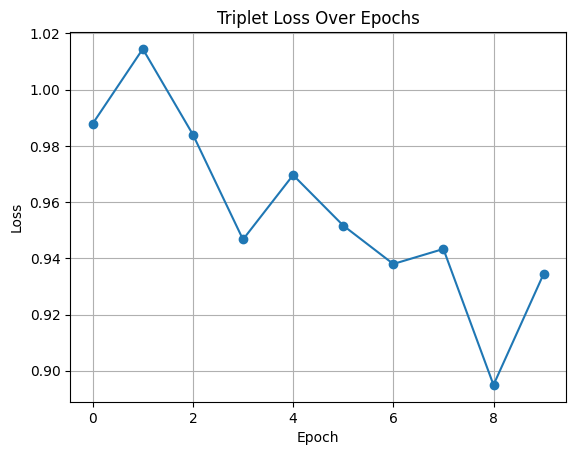

In [17]:
# plot loss
plot_loss(losses)

/Users/georgiavonminden/virtual-env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


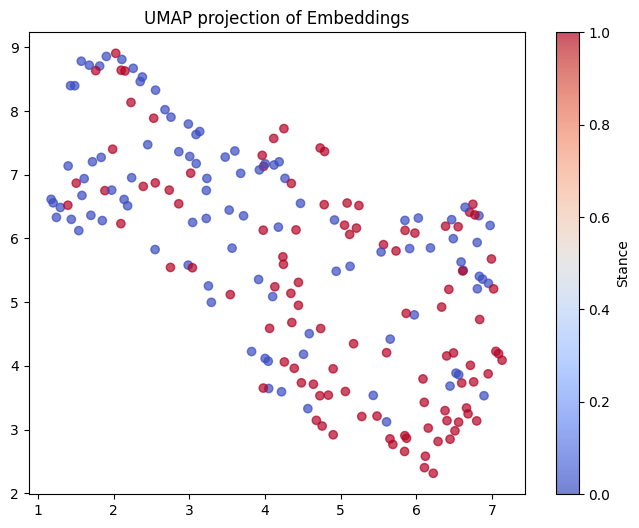

In [18]:
# visualize final embeddings
visualize_embeddings(model, df)

In [ ]:
X